In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from palettable.colorbrewer.qualitative import Dark2_5, Set1_3
import astropy.units as u

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

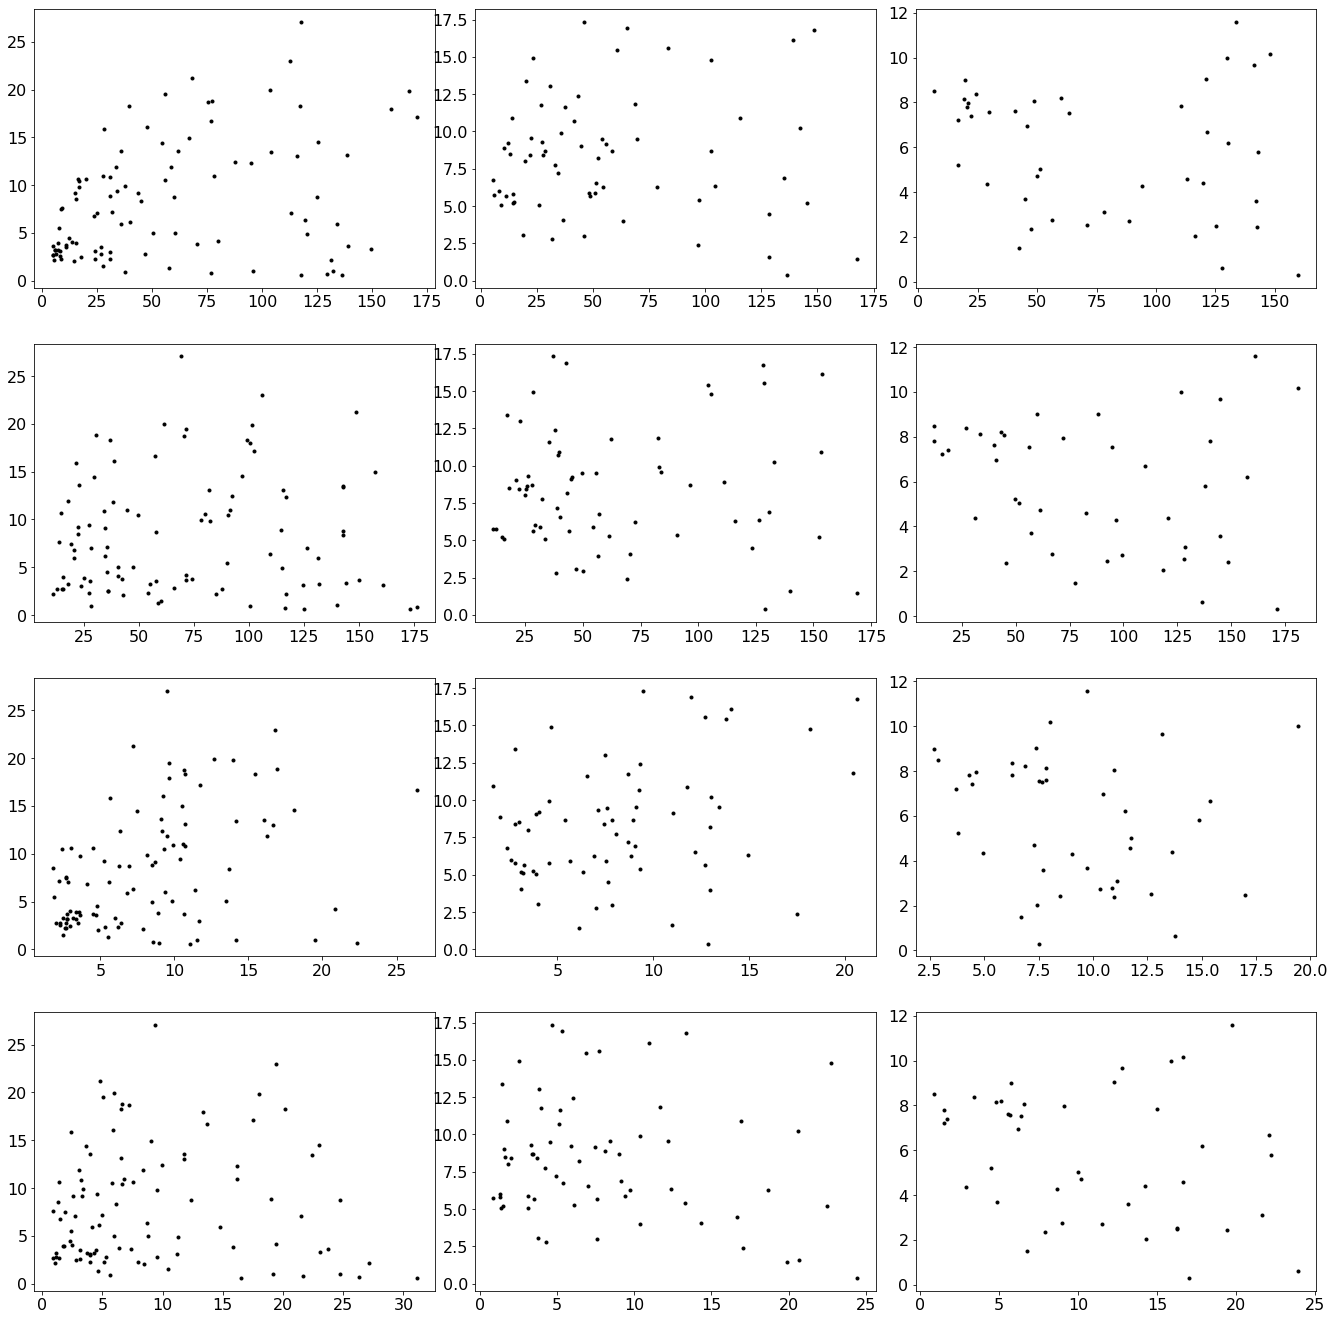

In [10]:
data_path = "C:/Users/yq904481/research/repos/GeoModelUncertainty/data/out_data/CME_scenarios_simulation_results.hdf5"
sim_data = h5py.File(data_path, 'r')

project_dirs = gmu.get_project_dirs()
fig, ax = plt.subplots(4,3, figsize=(20, 20))
for i, scenario in enumerate(['average', 'fast', 'extreme']):
    
    elevo_key = 'ELEvoHI_' + scenario
    elevo = pd.read_csv(project_dirs[elevo_key], delim_whitespace=True)
    
    elevo['v_b_std'] = 0
    elevo['v_std'] = 0
    elevo['dv_b_std'] = 0
    elevo['dv_std'] = 0
    
    for j, row in elevo.iterrows():
        
        sim_path = "/".join([scenario, row['run'], 'v_b_std'])
        elevo.loc[j, 'v_b_std'] = sim_data[sim_path][()]
        
        sim_path = "/".join([scenario, row['run'], 'v_std'])
        elevo.loc[j, 'v_std'] = sim_data[sim_path][()]
        
        sim_path = "/".join([scenario, row['run'], 'dv_b_std'])
        elevo.loc[j, 'dv_b_std'] = sim_data[sim_path][()]
        
        sim_path = "/".join([scenario, row['run'], 'dv_std'])
        elevo.loc[j, 'dv_std'] = sim_data[sim_path][()]
        
    # Now plot error vs v_boundary var for L5.
    id_l5 = elevo['sep'] == 300
    
    ax[0, i].plot(elevo.loc[id_l5, 'v_b_std'], elevo.loc[id_l5, 'mae_t'],'k.')
    
    ax[1, i].plot(elevo.loc[id_l5, 'v_std'], elevo.loc[id_l5, 'mae_t'],'k.')
    
    ax[2, i].plot(elevo.loc[id_l5, 'dv_b_std'], elevo.loc[id_l5, 'mae_t'],'k.')
    
    ax[3, i].plot(elevo.loc[id_l5, 'dv_std'], elevo.loc[id_l5, 'mae_t'],'k.')
    
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.99, top=0.99, wspace=0.1)
    
#for a in ax:
#    a.set_xlim(0, 170)
#    a.set_ylim(0, 30)
sim_data.close()        

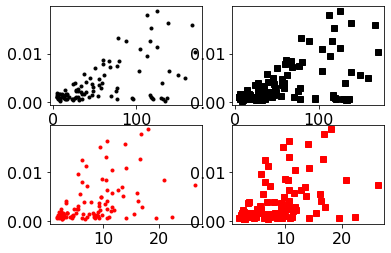

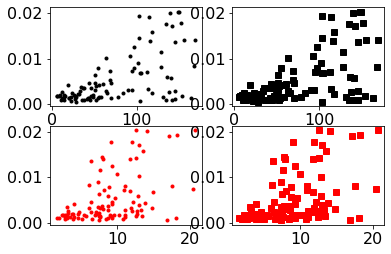

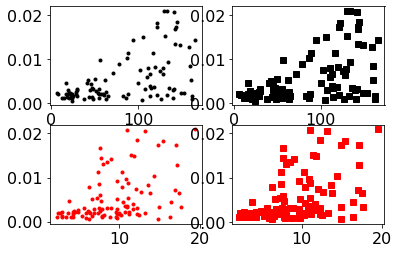

In [23]:
data_path = "C:/Users/yq904481/research/repos/GeoModelUncertainty/data/out_data/CME_scenarios_simulation_results.hdf5"
data = h5py.File(data_path, 'r')

scenario_keys = ['average', 'fast', 'extreme']
gm_keys = ['fp', 'hm', 'sse', 'elp']
gm_cols = {gk:Dark2_5.mpl_colors[i] for i, gk in enumerate(gm_keys)}
gm_style = {'fp':'x-', 'hm':'s-', 'sse':'^-', 'elp':'d-' }
gm_labels = {'fp':'FP', 'hm':'HM', 'sse':'SSE', 'elp':'ElCon'}
observer_lons = data['average/run_000/observer_lons'][()]
observer_keys = ["Observer {:3.2f}".format(l) for l in observer_lons]

gk = 'fp'
ok = "Observer 300.00"
scale = 1*u.AU.to(u.km)

for i, sk in enumerate(scenario_keys):

    scenario = data[sk]

    r_path = "/".join(['cme_apex','r'])
    rg_path = "/".join(['observers', ok, gk, 'r_apex'])
    r_int_limit = 0.5
    sum_err = []
    sum_abs_err = []
    v_std = []
    dv_std = []
    
    for r_key, run in scenario.items():
        
        v_std.append(run['v_b_std'][()])
        dv_std.append(run['dv_b_std'][()])
        
        # Get the HUXt and GM apex distances
        r = run[r_path][()]/scale
        rg = run[rg_path][()]/scale

        # Find only the valid values in each and compute the error and absolute error
        id_good = np.isfinite(r) & np.isfinite(rg)
        r = r[id_good]
        rg = rg[id_good]
        err = rg - r
        abs_err = np.abs(err)

        # Integrate the errors up to r_int_limit, save to array
        id_sub = r <= r_int_limit
        err_intg = np.trapz(err[id_sub], r[id_sub])
        sum_err.append(err_intg)

        abs_err_intg = np.trapz(abs_err[id_sub], r[id_sub])
        sum_abs_err.append(abs_err_intg)

    fig, ax = plt.subplots(2, 2)
    ax[0, 0].plot(v_std, sum_err, 'k.')
    ax[0, 1].plot(v_std, sum_abs_err, 'ks')
    ax[1, 0].plot(dv_std, sum_err, 'r.')
    ax[1, 1].plot(dv_std, sum_abs_err, 'rs')
    
data.close()